# Data Preparation

## Make Dataset

Data from https://nrc-digital-repository.canada.ca/eng/view/object/?id=1343ae23-cebf-45c6-94c3-ddebdb2f23c6

Paper: https://journals.aps.org/pra/abstract/10.1103/PhysRevA.96.042113

In [1]:
import torch
from QuantumDataset import QuantumDataset

torch.cuda.empty_cache()
dset = QuantumDataset('random')
files = dset.get_files()

RND_0011.h5
calculated_energy: (5000, 1)
eigenvalues: (5000, 5)
potential: (5000, 1, 256, 256)
wavefunction: (5000, 1, 256, 256)



  0%|          | 0/1 [00:00<?, ?it/s]

## Image Plotting Function

In [2]:
import matplotlib.pyplot as plt
def print_img(potential,wavefunction,title1=None,title2=None,energy=None,potential_label=None,E=None):
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    cmap = 'viridis'

    img = ax[0].imshow(potential.permute(1,2,0).cpu().numpy(),cmap=cmap)
    plt.colorbar(img)
    ax[0].set_title(title1)
    ax[0].axis('image')
    if potential_label is not None:
        ax[0].set_xlabel(files[potential_label.item()])
    ax[0].tick_params(labelbottom=False,labelleft=False)

    img = ax[1].imshow(wavefunction.permute(1,2,0).cpu().numpy(),cmap=cmap)
    plt.colorbar(img)
    ax[1].set_title(title2)
    ax[1].axis('image')
    if energy is not None:
        if E is not None:
            ax[1].set_xlabel(f'E_true = {energy.item():.2f}\nE_calc = {E:.2f}')
        else:
            ax[1].set_xlabel(f'E = {energy.item():.2f}')
    ax[1].tick_params(labelbottom=False,labelleft=False)

    plt.show()
    plt.close(fig)


## Sample Data

tensor(1.)


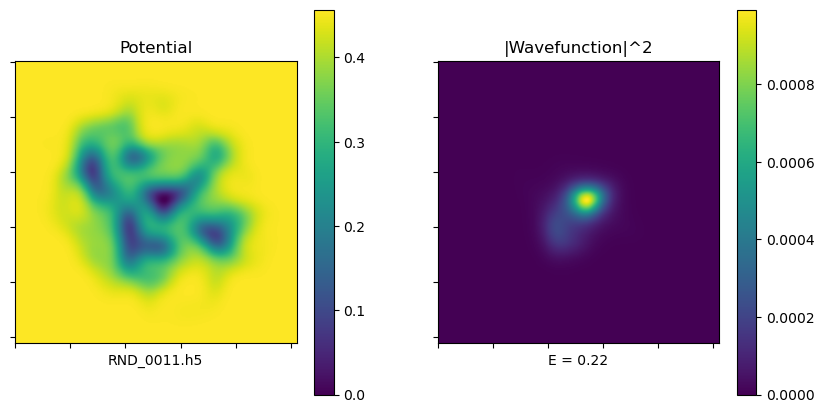

In [3]:
#sample_idx = [0,5000,10000,15000,20000]
sample_idx = [0]
for idx in sample_idx:
    potential = dset[idx]['potential']
    wavefunction = dset[idx]['wavefunction']
    energy = dset[idx]['energy']
    potential_label = dset[idx]['potential_label']
    print(wavefunction.sum())
    print_img(potential,wavefunction,'Potential','|Wavefunction|^2',energy,potential_label)

## Split Data

In [4]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(dset, test_size=0.2, shuffle=True)# set random-state later
train_dataset, validation_dataset = train_test_split(train_dataset, test_size=0.2, shuffle=True)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Part 1

## Create Model

In [5]:
from torch import nn
import math

class EnergyCNN(nn.Module):
    def __init__(self, cnn_channels, hidden_layers = ()):
        super().__init__()

        cnn_layers = []
        if cnn_channels:
            cnn_layers.append(nn.Conv2d(1,cnn_channels[0][0],cnn_channels[0][1],stride=cnn_channels[0][2],padding=cnn_channels[0][3], padding_mode='replicate'))
            cnn_layers.append(nn.ReLU())
            for i in range(len(cnn_channels)-1):
                cnn_layers.append(nn.Conv2d(cnn_channels[i][0],cnn_channels[i+1][0],cnn_channels[i+1][1],stride=cnn_channels[i+1][2],padding=cnn_channels[i+1][3], padding_mode='replicate'))
                cnn_layers.append(nn.ReLU())

        self.cnn_stack = nn.Sequential(*cnn_layers)
        cnn_output = self.cnn_stack(torch.zeros(1,256,256))
        print(cnn_output.shape)

        linear_layers = []
        if hidden_layers:
            linear_layers.append(nn.Flatten())
            linear_layers.append(nn.Linear(cnn_output.numel(),hidden_layers[0]))
            linear_layers.append(nn.ReLU())
            for i in range(len(hidden_layers)-1):
                linear_layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
                linear_layers.append(nn.ReLU())
            linear_layers.append(nn.Linear(hidden_layers[-1], 1))
        else:
            linear_layers.append(nn.Linear(math.prod(cnn_output),1))
        self.linear_stack = nn.Sequential(*linear_layers)

    def forward(self,X):
        X = self.linear_stack(self.cnn_stack(X))
        return X

## Train Model

In [6]:
from tqdm.notebook import tqdm

def energy_test(model,dataloader,loss_fn,device,validate=False):
    model.eval()
    losses = []
    with torch.inference_mode():
        for data in dataloader:
            X = data['potential'].to(device)
            y = data['energy'].to(device)
            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            losses.append(loss.item())
        average_loss = sum(losses) / len(losses)
        test_type = 'Validation' if validate else 'Test'
        tqdm.write(f'{test_type} Loss: {average_loss}\n')

In [7]:
def energy_train(model,epochs,train_dataloader,validation_dataloader,optimizer,loss_fn,device='cuda'):
    for epoch in tqdm(range(epochs),position=0):
        model.train()
        losses = []
        for data in tqdm(train_dataloader,leave=False,position=1):
            optimizer.zero_grad()
            X = data['potential'].to(device)
            y = data['energy'].to(device)

            loss = loss_fn(model(X), y)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

        avg_loss = sum(losses) / len(losses)

        tqdm.write(f'Epoch {epoch + 1}/{epochs}\nTrain Loss: {avg_loss}')

        energy_test(model,validation_dataloader,loss_fn,device,validate=True)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = EnergyCNN(cnn_channels=((64,3,2,1),
                                (16,3,2,1),
                                (64,3,2,1),
                                (16,3,2,1)),
                  hidden_layers=(64,),
                  ).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

epochs = 1
energy_train(model,epochs,train_dataloader,validation_dataloader,optimizer,loss_fn,device)
energy_test(model,test_dataloader,loss_fn,device,validate=False)


torch.Size([16, 16, 16])


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/1
Train Loss: 0.008172115460038185
Validation Loss: 0.005194398369640112

Test Loss: 0.004831614349746988



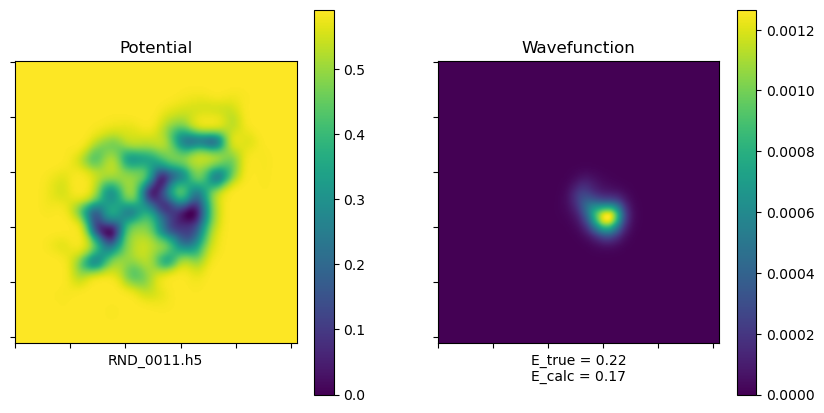

In [9]:
presentation_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

limit = 1
model.eval()
for i, data in enumerate(presentation_dataloader):
    if i >= limit:
        break

    potential = data['potential']
    wavefunction = data['wavefunction']
    energy = data['energy']
    potential_label = data['potential_label']
    with torch.inference_mode():
        E = model.forward(potential.to(device)).item()
        print_img(potential.squeeze(dim=0),wavefunction.squeeze(dim=0),'Potential','Wavefunction',energy,potential_label,E)

# Part 2

## Energy Loss

Based on the time-independent schrodinger equation

|-1/2(d^2psi/dx^2 + d^2psi/dy^2) + (V-E)psi| = loss

-> -1/2 delta^2 psi + (V-E)psi = loss

To find E: use variational approach: E_ground = min(<psi|H|psi>)

H = -1/2 delta^2 + V

In [10]:
from torch import nn

class energy_loss(nn.Module):
    def __init__(self,alpha=1,dx=0.157,loss_fn=nn.L1Loss(reduction='sum')):
        super().__init__()
        self.alpha = alpha
        self.loss_fn = loss_fn
        with torch.no_grad():
            self.laplacian = nn.Conv2d(in_channels=1,out_channels=1,kernel_size=3,padding=1,padding_mode='reflect',bias=False)
            kernel = torch.tensor([[0, 1, 0],
                                   [1, -4, 1],
                                   [0, 1, 0]]).reshape(1,1,3,3)
            self.laplacian.weight[:] = kernel/(dx**2)
    def forward(self,potential,wavefunction,energy):
        E = self.get_energy(wavefunction,potential)
        loss = self.loss_fn(E,energy)
        return loss*self.alpha

    def get_ke(self,wavefunction):
        return -1/2 * self.laplacian(wavefunction)

    def get_energy(self,wavefunction,potential):
        E = (self.get_ke(wavefunction) * wavefunction + potential * wavefunction**2).sum(dim=(2,3))/(wavefunction**2).sum(dim=(2,3))
        return E



## Create Model

In [11]:
class WavefunctionPINN(nn.Module):
    def __init__(self,channels=None,dx=0.157):
        super().__init__()
        self.dx = dx
        self.start = nn.Sequential(nn.BatchNorm2d(1),
                                   nn.Conv2d(in_channels=1,out_channels=channels[0],kernel_size=3,padding=1,padding_mode='reflect'),
                                   nn.BatchNorm2d(channels[0]),
                                   nn.ReLU(),
                                   nn.Conv2d(in_channels=channels[0],out_channels=channels[0],kernel_size=3,padding=1,padding_mode='reflect'),
                                   nn.BatchNorm2d(channels[0]),
                                   nn.ReLU())
        self.end = nn.Sequential(nn.Conv2d(in_channels=channels[0],out_channels=1,kernel_size=3,padding=1,padding_mode='reflect'),
                                 nn.Tanh()
                                 )
        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        for i in range(1,len(channels)):
            self.encoders.append(self.make_encoder(channels[i-1],channels[i]))
            self.decoders.append(self.make_decoder(channels[i],channels[i-1],channels[i-1]))
        self.bridge = nn.Sequential(
            nn.Conv2d(in_channels=channels[-1],out_channels=channels[-1],kernel_size=3,padding=1,padding_mode='reflect'),
            nn.BatchNorm2d(channels[-1]),
            nn.ReLU(),
            nn.Conv2d(in_channels=channels[-1],out_channels=channels[-1],kernel_size=3,padding=1,padding_mode='reflect'),
            nn.BatchNorm2d(channels[-1]),
            nn.ReLU(),
            nn.Conv2d(in_channels=channels[-1],out_channels=channels[-1],kernel_size=3,padding=1,padding_mode='reflect'),
            nn.BatchNorm2d(channels[-1]),
            nn.ReLU(),
        )

    def forward(self,X):

        X = self.start(X)
        encoded_levels = []
        for encoder in self.encoders:
            encoded_levels.append(X)
            X = encoder(X)
        X = self.bridge(X)
        for i in range(len(self.decoders)-1,-1,-1):
            X = self.decoders[i]['decode'](X)
            X = self.decoders[i]['convolution'](torch.cat((X, encoded_levels[i]), dim=1))
        X = self.end(X)
        X = X * torch.sqrt(1/(X**2).sum(dim=(1,2,3),keepdim=True))#*self.dx**2)
        return X

    def make_encoder(self,input_size,output_size):
        return nn.Sequential(nn.AvgPool2d(kernel_size=2,stride=2),
                             nn.Conv2d(in_channels=input_size,out_channels=output_size,kernel_size=3,padding=1,padding_mode='reflect'),
                             nn.BatchNorm2d(output_size),
                             nn.ReLU(),
                             nn.Conv2d(in_channels=output_size,out_channels=output_size,kernel_size=3,padding=1,padding_mode='reflect'),
                             nn.BatchNorm2d(output_size),
                             nn.ReLU())

    def make_decoder(self,input_size,output_size,skip_size):
        return nn.ModuleDict({'decode':nn.Sequential(nn.Upsample(scale_factor=2,mode='bilinear'),
                                                     nn.Conv2d(in_channels=input_size,out_channels=output_size,kernel_size=3,padding=1,padding_mode='reflect'),
                                                     nn.BatchNorm2d(output_size),
                                                     nn.ReLU()),
                              'convolution':nn.Sequential(nn.Conv2d(in_channels=output_size+skip_size,out_channels=output_size,kernel_size=3,padding=1,padding_mode='reflect'),
                                                          nn.BatchNorm2d(output_size),
                                                          nn.ReLU(),
                                                          nn.Conv2d(in_channels=output_size,out_channels=output_size,kernel_size=3,padding=1,padding_mode='reflect'),
                                                          nn.BatchNorm2d(output_size),
                                                          nn.ReLU(),
                                                          )})


tmodel = WavefunctionPINN(channels=(32,64,128,256)) #add change to decoder to allow any number for layers
input = torch.randn(1,1,256,256)
output = tmodel(input)
print(output.shape)

torch.Size([1, 1, 256, 256])


## Train Model

In [12]:
from tqdm.notebook import tqdm

def wavefunction_test(model,dataloader,loss_fn,input='potential',target='wavefunction',validate=False,device='cuda'):
    model.eval()
    losses = []
    with torch.inference_mode():
        for data in tqdm(dataloader, leave=False):
            X = data[input].to(device)
            y = data[target].to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred**2, y)
            losses.append(loss.item())
        average_loss = sum(losses) / len(losses)
        test_1 = nn.MSELoss(reduction='sum')
        test_2 = nn.L1Loss(reduction='sum')
        tqdm.write(f'L1: {test_2(y_pred**2,y)}, MSE: {test_1(y_pred,y)}')
        test_type = 'Validation' if validate else 'Test'
        tqdm.write(f'{test_type} Loss: {average_loss}\n')

In [13]:
def wavefunction_train(model,
                       epochs,
                       train_dataloader,
                       validation_dataloader,
                       optimizer,
                       loss_fn,
                       energy_loss_fn,
                       input='potential',
                       target='wavefunction',
                       device='cuda'):

    for epoch in tqdm(range(epochs),position=0):
        model.train()
        regular_losses = []
        energy_losses = []
        for data in tqdm(train_dataloader,leave=False,position=1):
            optimizer.zero_grad()
            X = data[input].to(device)
            y = data[target].to(device)
            energy = data['energy'].to(device)

            psi = model(X)
            regular_loss = loss_fn(psi**2, y)
            energy_loss = energy_loss_fn(psi,X,energy)
            energy_losses.append(energy_loss.item())

            loss = regular_loss
            if torch.isnan(loss):
                print('Loss is NaN!')
                return None

            regular_losses.append(regular_loss.item())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            for name, param in model.named_parameters():
                if torch.isnan(param.grad).any():
                    print(f"NaN gradient in {name}!")
                    return None
            optimizer.step()

        avg_regular_loss = sum(regular_losses) / len(regular_losses)
        avg_energy_loss = sum(energy_losses) / len(energy_losses)

        tqdm.write(f'''Epoch {epoch + 1}/{epochs}
        Train Regular Loss: {avg_regular_loss}
        Train Energy Loss: {avg_energy_loss}''')
        wavefunction_test(model,validation_dataloader,loss_fn,input=input,target=target,validate=True,device=device)
    return None

## Loop

In [14]:
class MixedLoss(nn.Module):
    def __init__(self,loss_fn1,loss_fn2,alpha):
        super().__init__()
        self.loss_fn1 = loss_fn1
        self.loss_fn2 = loss_fn2
        self.alpha = alpha

    def forward(self,y_pred,y_true):
        return self.loss_fn1(y_pred,y_true) + self.loss_fn2(y_pred,y_true) * self.alpha


In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model2 = WavefunctionPINN(channels=(8,16,32,64,128),dx=0.157).to(device)

optimizer = torch.optim.AdamW(model2.parameters(), lr=0.0001)
#optimizer = torch.optim.SGD(model2.parameters(), lr=0.01)
#optimizer = torch.optim.Adagrad(model2.parameters(), lr=0.01, lr_decay=0.01)
#optimizer = torch.optim.RMSprop(model2.parameters())

#loss_fn = nn.MSELoss(reduction='sum').to(device) #bad? maybe try hybrid using this for outliers?
loss_fn = nn.L1Loss(reduction='sum').to(device) #good for wf to wf/ best so far for all
#loss_fn = MixedLoss(nn.L1Loss(reduction='sum'),nn.MSELoss(reduction='sum'),alpha = 1).to(device)

energy_loss_fn = energy_loss(alpha=10,dx=0.157,loss_fn=nn.L1Loss(reduction='sum')).to(device)
epochs = 10
#epochs = 1

input = 'potential'
#input = 'wavefunction'
target = 'wavefunction'
wavefunction_train(model2,epochs,train_dataloader,validation_dataloader,optimizer,loss_fn,energy_loss_fn,input=input,target=target,device=device)
wavefunction_test(model2,test_dataloader,loss_fn,input=input,target=target,validate=False,device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/10
        Train Regular Loss: 7.058337584733963
        Train Energy Loss: 27.848871994018555


  0%|          | 0/50 [00:00<?, ?it/s]

L1: 4.615128517150879, MSE: 16.089574813842773
Validation Loss: 3.9394443941116335



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 2/10
        Train Regular Loss: 3.429476307630539
        Train Energy Loss: 27.85718970298767


  0%|          | 0/50 [00:00<?, ?it/s]

L1: 4.092741012573242, MSE: 16.443889617919922
Validation Loss: 3.008610601425171



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 3/10
        Train Regular Loss: 2.651239535212517
        Train Energy Loss: 27.862959718704225


  0%|          | 0/50 [00:00<?, ?it/s]

L1: 1.491703987121582, MSE: 16.587915420532227
Validation Loss: 2.0470324683189394



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 4/10
        Train Regular Loss: 2.043344283699989
        Train Energy Loss: 27.87179301261902


  0%|          | 0/50 [00:00<?, ?it/s]

L1: 2.4927849769592285, MSE: 16.678852081298828
Validation Loss: 2.16534481048584



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 5/10
        Train Regular Loss: 1.7857567635178566
        Train Energy Loss: 27.87287081718445


  0%|          | 0/50 [00:00<?, ?it/s]

L1: 1.8500339984893799, MSE: 16.639995574951172
Validation Loss: 1.8150928544998168



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 6/10
        Train Regular Loss: 1.609172901213169
        Train Energy Loss: 27.873941564559935


  0%|          | 0/50 [00:00<?, ?it/s]

L1: 0.9941314458847046, MSE: 16.648653030395508
Validation Loss: 1.1052711951732634



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 7/10
        Train Regular Loss: 1.4506817683577538
        Train Energy Loss: 27.8756729221344


  0%|          | 0/50 [00:00<?, ?it/s]

L1: 1.7259081602096558, MSE: 16.648975372314453
Validation Loss: 1.3992815363407134



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 8/10
        Train Regular Loss: 1.3642755702137948
        Train Energy Loss: 27.87457943916321


  0%|          | 0/50 [00:00<?, ?it/s]

L1: 1.558181643486023, MSE: 16.594497680664062
Validation Loss: 1.3268523681163789



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 9/10
        Train Regular Loss: 1.2877690586447716
        Train Energy Loss: 27.874545698165893


  0%|          | 0/50 [00:00<?, ?it/s]

L1: 1.1569907665252686, MSE: 16.600784301757812
Validation Loss: 1.2401842510700225



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 10/10
        Train Regular Loss: 1.1370949995517732
        Train Energy Loss: 27.874061908721924


  0%|          | 0/50 [00:00<?, ?it/s]

L1: 0.9239510297775269, MSE: 16.660524368286133
Validation Loss: 1.1347281181812285



  0%|          | 0/63 [00:00<?, ?it/s]

L1: 0.3917784094810486, MSE: 8.301176071166992
Test Loss: 0.9772145171014089



In [ ]:
#torch.save(model2.state_dict(), 'Data/Models/model_state_dict.pt')
#print(torch.cuda.memory_summary())

## Results

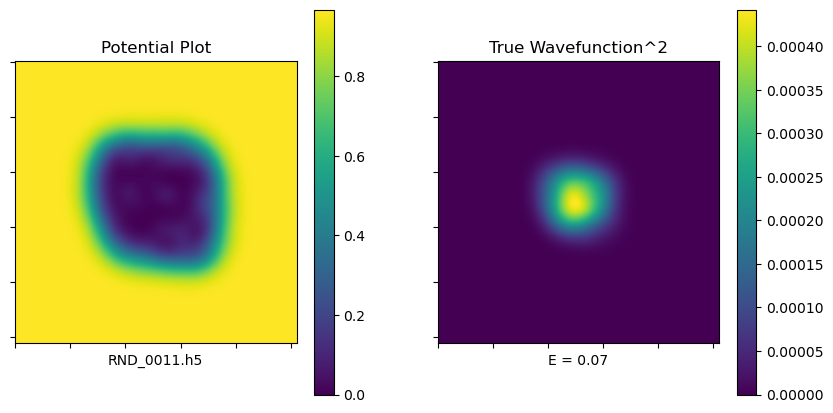

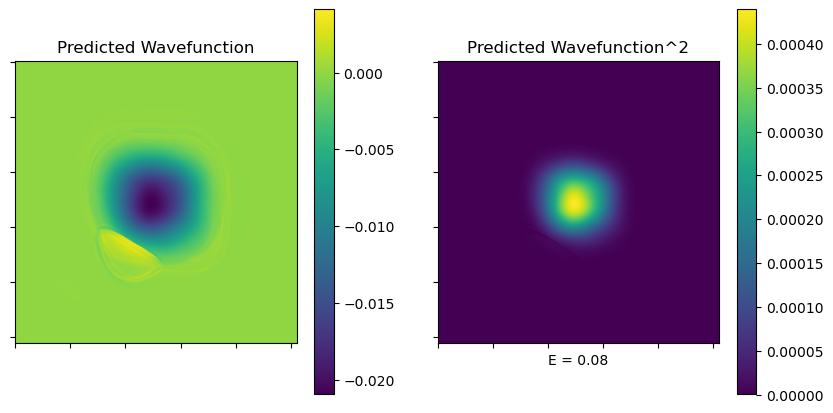

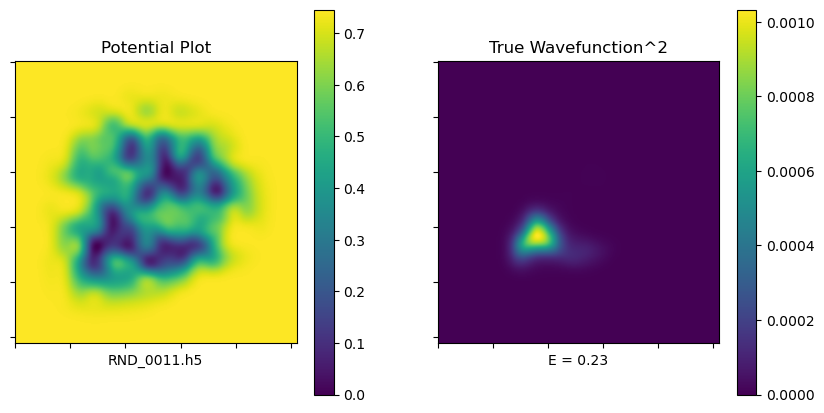

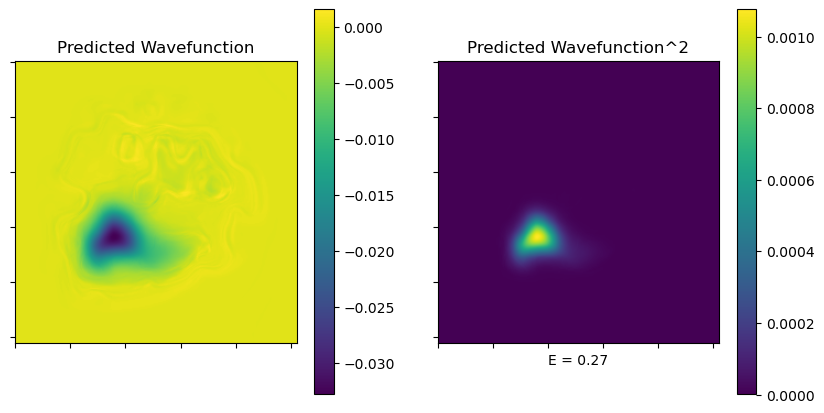

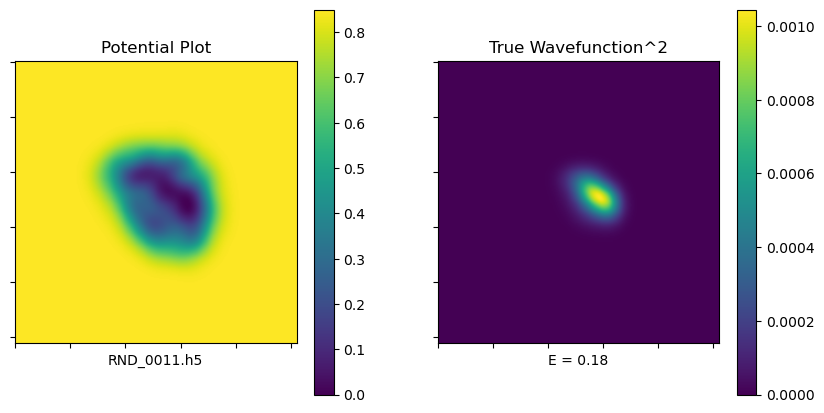

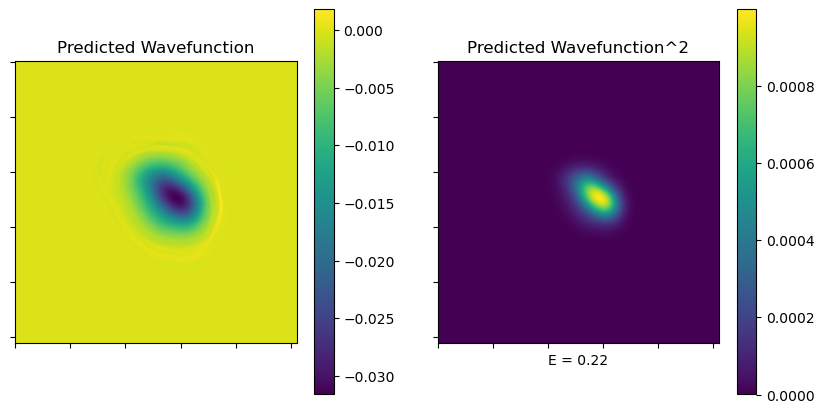

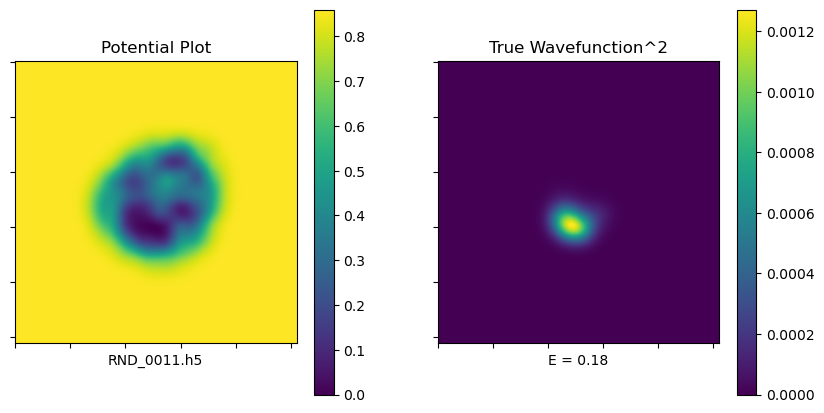

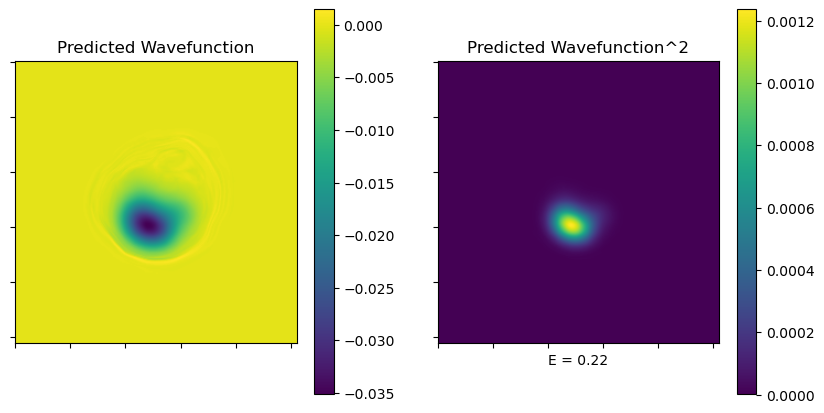

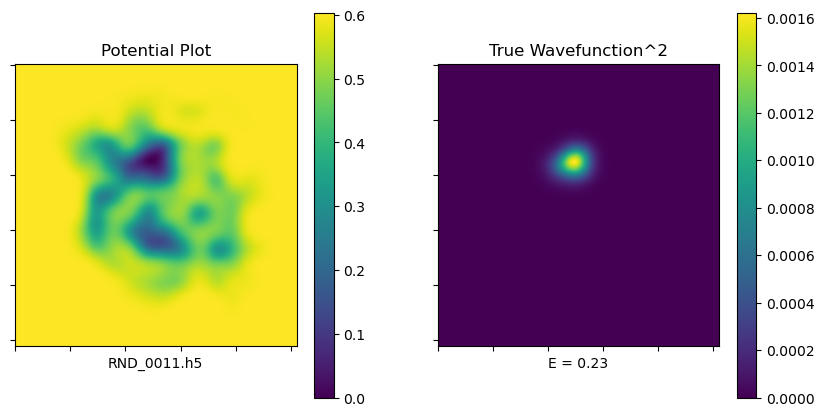

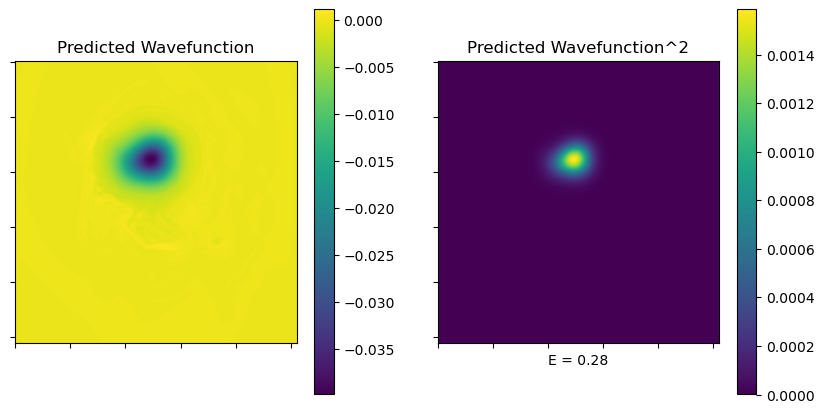

In [17]:
presentation_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

limit = 5
model2.eval()
for i, data in enumerate(presentation_dataloader):
    if i >= limit:
        break

    potential = data[input]
    wavefunction = data[target]
    energy = data['energy']
    potential_label = data['potential_label']
    with torch.inference_mode():
        wf = model2.forward(potential.to(device))
        wavefunction_guess = wf**2
        energy_guess = energy_loss_fn.get_energy(wavefunction.to(device),potential.to(device))

        print_img(potential.squeeze(dim=0),wavefunction.squeeze(dim=0),'Potential Plot','True Wavefunction^2',energy=energy,potential_label=potential_label)
        print_img(wf.squeeze(dim=0),wavefunction_guess.squeeze(dim=0),'Predicted Wavefunction','Predicted Wavefunction^2',energy=energy_guess)